In [1]:
import numpy as np
import os
# from scipy import signal
import UDIP_Lib_V19 as UDIP_Lib  #making updating UDIP_Lib easier
import RockSat_1_14_fitting_functions as R_fitting
import json
import matplotlib.pyplot as plt
from RockSat_json import *
from scipy.optimize import *

In [2]:
year = 2021
packets = import_data(f'/Users/joshuagoodwill/packets/{year}_packet.json')

sw_num = 1200
V_arr = np.array(packets['packets']['Medium'][f'{sw_num}']['Voltage'])
I_arr = np.array(packets['packets']['Medium'][f'{sw_num}']['Current0'])

In [3]:
packets['packets']['Medium']['0'].keys()

dict_keys(['Start', 'Stop', 'Count', 'Voltage', 'Current0', 'Current1', 'Current2'])

In [4]:
import numpy as np
from scipy.optimize import curve_fit

'''
def gen_fit(x, y):
Generates fit of linear and sqrt portion of IV arrays. Refer to
data_processing to idenify filtering of IV arrays. scipy.optimize.curve_fit
used to fit non-linear least squares to fit

input:
V_arr (array); Voltage array
I_arr (array); Current array
proc* (boolean); Whether to process the arrays for better fitting

output:
V_fit (np.array); linear space between min and max voltages from V_arr
model(t, *popt) (np.array); fitted model of I_arr using Voltage range and 
                            pointer to popt
popt(array); optimal values for parameters
  V_f  (float) = popt[0]; Plasma potential
  m1   (float) = popt[1]; slope of linear fit
  b    (float) = popt[2]  (float); y-intercept of linear fit
  ne   (float) = popt[3]; electron density [cm^{-3}]
  etemp(float) = popt[4]; electron temperature [K]
  VP   (float) = popt[5]; plasma potential [V]
  
pcov(2D np.array); covariance of popt array
'''

def gen_fit(V_arr, I_arr, proc = False):
    V_proc = []
    I_proc = []
    if proc == True:
        V_proc, I_proc = data_processing(V_arr, I_arr)
    else:
        V_proc, I_proc = V_arr, I_arr
    guess = [0.6, 100, 80, 8*(10**10), 1000,0.5]    #intial guess
    b = ((0,-1000,-100,0,0,0.01),(1,1000,100,np.inf,10000,3)) #bounds
    popt, pcov = curve_fit(model, V_proc, I_proc, guess, bounds = b)
    V_fit = np.linspace(min(V_proc),max(V_proc), num = 200) #Voltage array processed for fit
    return V_fit, model(V_fit,*popt), popt, pcov

'''
def model(V_proc, VP, m1, b, ne, etemp, V0):
Model to fit ion, *transition*, electron saturation regions

input:
V_proc (np.array); processed V_arr for fitting
Vf (float); floating potential
m1 (float); slope of linear fit
b  (float); y-intercept of linear fit
ne (float); electron density [cm^{-2}]
etemp(float); electron temperature [K]
VP (float); plasma potential [V]
'''

def model(V_proc, Vf, m1, b, ne, etemp, VP):
    I_fit = np.zeros(len(V_proc))
    #Linear fit for ion saturation
    I_fit[V_proc <= Vf] = lin_fit(V_proc[V_proc <= Vf], m1, b) 
    #Sqrt fit for electron saturation
    I_fit[V_proc > Vf] = sqrt_fit(V_proc[V_proc > Vf], ne, etemp ,VP) \
                         - sqrt_fit(Vf, ne , etemp, VP)
    return I_fit

def lin_fit(x, m, y_int): #linear--full model square root
    return m * x + y_int

'''
def sqrt_fit(x, ne, etemp, V0)
Uses Eq. 1.4 and 1.5 of https://digitalcommons.usu.edu/etd/274

input:
x (np.array); V_proc [V]
ne (float); electron density [cm?]
etemp(float); electron temperature [K]
VP (float); negative plasma potential [V]

output:
I (float); current fit [nA]
'''
def sqrt_fit(x, ne, etemp, VP):# square root
    q_e = 1.602 * 10**-19 #electron charge [C]
    K_b = 1.381 * 10**-23 #boltzman constant [m^2*kg/(s^2*K)]   
    m_e = 9.109 * 10**-31 #electron mass [kg]              
    R = (3./16.) * 0.0254 #radius of probe [cm?]
    L = (3.25) * 0.0254 #length of probe [cm?]
    A = 2. * np.pi * R * L + np.pi * (R ** 2) #top and length area of cylinder [cm^2]

    k = q_e / (K_b * etemp)
    I0 = ne * q_e * np.sqrt(K_b * etemp / (2. * np.pi * m_e)) * A / (10**-9)
    return I0 * np.sqrt(1. + k*(x - VP))

'''
def data_processing(V, I)
Processes Voltage and Current arrays to reduce points for fitting algorithm.
Removes Voltage below -3 V and above first max of Current array

input:
V (np.array); Normal Voltage array
I (np.array); Normal Current array

output:
V_proc (np.array); processed Voltage array
I_proc (np.array); processed Current array
'''

def data_processing(V, I):
    Imax = np.argmax(I) #find index of maximum Current
    if (Imax.size != 1):
        Vmin_Imax = np.argmin(V[Imax]) #find lowest voltage value with max current
    else:
        Vmin_Imax = Imax
    V_rem = (V > -3) & (V < V[Vmin_Imax]) #array of voltages > -3V and < Vmin_Imax
    V_proc = V[V_rem]
    I_proc = I[V_rem]
    return V_proc, I_proc


In [5]:
V_proc, I_proc = data_processing(V_arr, I_arr)
V_fit, I_fit, params, cov = gen_fit(V_arr, I_arr, proc = False)
V_fit1, I_fit1, params, cov = gen_fit(V_proc, I_proc, proc = False)
# generate_fit(V_arr, I_arr)

/var/folders/vd/xvmkswd51pn4d88fylf_g0kh0000gn/T/ipykernel_7467/3144333246.py:92: RuntimeWarning: invalid value encountered in sqrt
  return I0 * np.sqrt(1. + k*(x - VP))


In [6]:
print(params[0])

0.5961516712975167


In [7]:
print(params)

[ 5.96151671e-01  5.90890109e+01 -4.23049662e+01  8.45000937e+10
  4.93616717e+02  6.09251655e-01]


In [8]:
n = 7
print(V_fit[n], I_fit[n])
Vf = 8
print(V_fit[Vf], I_fit[Vf])
print(params)

-5.288944490290162 -313.92981538123774
-5.228731600483364 -311.0517080085588
[ 5.96151671e-01  5.90890109e+01 -4.23049662e+01  8.45000937e+10
  4.93616717e+02  6.09251655e-01]


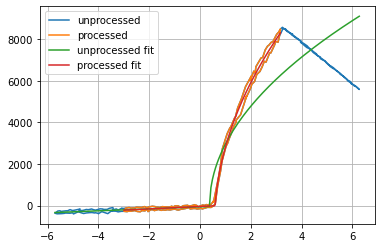

In [13]:
plt.plot(V_arr, I_arr, label = "unprocessed")
plt.plot(V_proc,I_proc, label = 'processed')
plt.plot(V_fit, I_fit, label = 'unprocessed fit')
plt.plot(V_fit1, I_fit1, label = 'processed fit')
plt.grid()
plt.legend()
plt.savefig('fit.jpg', dpi = 500)

(0.5, 3.0)

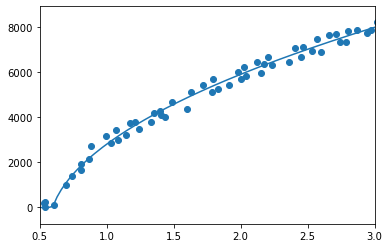

In [10]:
plt.plot(V_fit1, I_fit1)
plt.scatter(V_proc, I_proc)

plt.xlim(0.5,3)

In [11]:
print(params)

[ 5.96151671e-01  5.90890109e+01 -4.23049662e+01  8.45000937e+10
  4.93616717e+02  6.09251655e-01]
